<a href="https://colab.research.google.com/github/howardx/agentic/blob/main/demo_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

In [1]:
!pip install --quiet -U langgraph langchain_openai langchain_core serpapi google-search-results

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 875.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 10.1 MB/s eta 0:00:00


## Environment Variable Setup -- API Keys

In [2]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("SERP_API_KEY")

OPENAI_API_KEY: ··········
SERP_API_KEY: ··········


## Let's Create Tools For Our LLM Assistant

In [3]:
import os
from serpapi.google_search import GoogleSearch
from typing import List, Dict

def get_airfare_details(
    departure_airport: str,
    destination_airport: str,
    departure_date: str,
    return_date: str
) -> List[Dict]:
    """
    Fetch round-trip airfare details between two airports using SerpAPI's Google Flights engine.

    Args:
        departure_airport (str): IATA airport code of the departure location (e.g., "CDG").
        destination_airport (str): IATA airport code of the destination (e.g., "SFO").
        departure_date (str): Outbound flight date in format YYYY-MM-DD.
        return_date (str): Return flight date in format YYYY-MM-DD.

    Returns:
        List[Dict]: A list of flights (both outbound and return), where each flight dict includes:
            - flight_number (str)
            - airline (str)
            - departure_time (str)
            - arrival_time (str)
            - departure_airport (str)
            - arrival_airport (str)
            - price (float)
            - departure_token (str)
    """
    def extract_flight_segments(flight_data: Dict, price: float, token: str) -> List[Dict]:
        return [
            {
                "flight_number": seg.get("flight_number"),
                "airline": seg.get("airline"),
                "departure_time": seg["departure_airport"].get("time"),
                "arrival_time": seg["arrival_airport"].get("time"),
                "departure_airport": seg["departure_airport"].get("id"),
                "arrival_airport": seg["arrival_airport"].get("id"),
                "price": price,
                "departure_token": token
            }
            for seg in flight_data.get("flights", [])
        ]

    # First search: outbound
    params = {
        "engine": "google_flights",
        "hl": "en",
        "gl": "us",
        "departure_id": departure_airport,
        "arrival_id": destination_airport,
        "outbound_date": departure_date,
        "return_date": return_date,
        "currency": "USD",
        "api_key": os.environ.get("SERP_API_KEY")
    }

    search = GoogleSearch(params)
    results = search.get_dict()

    best_flight = results.get("best_flights", [])[0] if results.get("best_flights") else None
    if not best_flight:
        return []

    outbound_segments = extract_flight_segments(
        best_flight,
        best_flight.get("price"),
        best_flight.get("departure_token")
    )

    # Second search: return
    params["departure_token"] = best_flight.get("departure_token")
    return_search = GoogleSearch(params)
    return_results = return_search.get_dict()

    return_flight = return_results.get("other_flights", [])[0] if return_results.get("other_flights") else None
    if not return_flight:
        print(return_results)
        return outbound_segments

    return_segments = extract_flight_segments(
        return_flight,
        best_flight.get("price"),
        best_flight.get("departure_token")
    )

    return outbound_segments + return_segments

In [12]:
get_airfare_details("SFO", "JFK", "2025-07-01", "2025-07-07")

[{'flight_number': 'AA 166',
  'airline': 'American',
  'departure_time': '2025-07-01 13:17',
  'arrival_time': '2025-07-01 22:00',
  'departure_airport': 'SFO',
  'arrival_airport': 'JFK',
  'price': 501,
  'departure_token': 'WyJDalJJVkZGQk5rbzFhRU5aTVRCQlNtZHNMWGRDUnkwdExTMHRMUzB0YjNsamFYQXhNMEZCUVVGQlIyaFBVVFF3VGtaclVEUkJFZ1ZCUVRFMk5ob0xDS1NIQXhBQ0dnTlZVMFE0SEhDa2h3TT0iLFtbIlNGTyIsIjIwMjUtMDctMDEiLCJKRksiLG51bGwsIkFBIiwiMTY2Il1dXQ=='},
 {'flight_number': 'AA 1',
  'airline': 'American',
  'departure_time': '2025-07-07 07:20',
  'arrival_time': '2025-07-07 10:22',
  'departure_airport': 'JFK',
  'arrival_airport': 'LAX',
  'price': 501,
  'departure_token': 'WyJDalJJVkZGQk5rbzFhRU5aTVRCQlNtZHNMWGRDUnkwdExTMHRMUzB0YjNsamFYQXhNMEZCUVVGQlIyaFBVVFF3VGtaclVEUkJFZ1ZCUVRFMk5ob0xDS1NIQXhBQ0dnTlZVMFE0SEhDa2h3TT0iLFtbIlNGTyIsIjIwMjUtMDctMDEiLCJKRksiLG51bGwsIkFBIiwiMTY2Il1dXQ=='},
 {'flight_number': 'AA 4893',
  'airline': 'American',
  'departure_time': '2025-07-07 14:25',
  'arrival_time': '

In [5]:
def city_to_iata(city_name: str) -> str:
    """
    Converts a popular city name to its nearest major airport's IATA (International Air Transport Association) code.

    Args:
        city_name (str): Common name of a city (e.g., "New York", "Paris").

    Returns:
        str: The IATA airport code (e.g., "JFK", "CDG") or "Unknown" if not found.
    """
    city_iata_map = {
        "new york": "JFK",
        "los angeles": "LAX",
        "san francisco": "SFO",
        "chicago": "ORD",
        "miami": "MIA",
    }

    return city_iata_map.get(city_name.strip().lower(), "Unknown")

## Define LLM Assistant

In [6]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")
plain_llm = ChatOpenAI(model="gpt-3.5-turbo")

In [7]:
tools = [get_airfare_details, city_to_iata]
llm_with_tools = llm.bind_tools(tools)

In [8]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

# System message
sys_msg = SystemMessage(content="""
You are a knowledgeable and helpful travel planning assistant.
Your task is to create a detailed travel itinerary based on the user's chosen destination. You should:

Search for and summarize flight options, including airline, departure/arrival time, flight number, layovers, and price.
Use tools when appropriate to fetch live airfare information.
The tool get_airfare_details is able to give you round trip airfare information with one call.

Organize the itinerary clearly, separating outbound and return details.
""")

# Node
def assistant(state: MessagesState):
   # source code: state, keeps track of messages between human, LLM and tools, i.e. the state
   # each LLM call will process the entire message history (full state)
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Let's Build A Stateful Graph That Represents Our Agentic AI Workflow

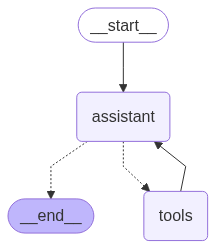

In [9]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # source code, routes the workflow based on LLM's reason
)
builder.add_edge("tools", "assistant")
graph = builder.compile()
graph

In [10]:
user_prompt = """help me to find the best airfare from San Francisco to new york during the July forth holiday,
I will be departing around July 1 2025 visiting for five days"""

print(plain_llm.invoke(user_prompt).content)

To find the best airfare from San Francisco to New York during the July Fourth holiday, consider the following tips:

1. Start your search early: Airlines typically release their tickets around 11 months in advance, so the earlier you start looking, the better chance you have of finding a good deal.

2. Use flight comparison websites: Utilize websites like Google Flights, Skyscanner, or Kayak to compare prices from different airlines and find the best deals.

3. Be flexible with your travel dates: If possible, consider flying a day or two before or after your preferred departure date to see if there are cheaper options available.

4. Sign up for fare alerts: Set up price alerts on flight search engines or sign up for newsletters from airlines to receive notifications of any price drops or deals on your desired route.

5. Check multiple airports: New York City has multiple airports, including JFK, LaGuardia, and Newark. Make sure to check fares for all three airports to see if one offer

In [13]:
messages = [HumanMessage(content=user_prompt)]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

help me to find the best airfare from San Francisco to new york during the July forth holiday,
I will be departing around July 1 2025 visiting for five days
================================== Ai Message ==================================
Tool Calls:
  city_to_iata (call_PyxkOlCMz3fXAmv1m0VbOfFa)
 Call ID: call_PyxkOlCMz3fXAmv1m0VbOfFa
  Args:
    city_name: San Francisco
================================= Tool Message =================================
Name: city_to_iata

SFO
================================== Ai Message ==================================
Tool Calls:
  city_to_iata (call_W2JiEnKrjlEY745q9Sd0DCos)
 Call ID: call_W2JiEnKrjlEY745q9Sd0DCos
  Args:
    city_name: New York
================================= Tool Message =================================
Name: city_to_iata

JFK
================================== Ai Message ==================================
Tool Calls:
  get_airfare_details (call_y